# Missing data patterns

Are there concerning patterns in missingness? In particular, does missingness change pre-post pandemic?

In [1]:
using DataFrames
using DataFramesMeta
using Plots
using StatsBase
using StatsModels
using Dates
using Plots.PlotMeasures
using GLM
using CSV
using CategoricalArrays
using Distributions
using Tables
using Revise
using LaTeXStrings
using Pipe
using CovarianceMatrices
using Distributions

In [2]:
using KFactors

In [3]:
raw_data = read_data("../data/peaks_merged.parquet", dropmissing=false)
nothing

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.83%)
└ @ KFactors C:\Users\mwbc\git\peak-spreading\src\computation.jl:65


In [4]:
data = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022, min_complete=0.0);

## Reasons for missingness

There are multiple ways data can be missing:
1. It can have small gaps that are imputed (e.g. because the modem failed to upload for a few minutes)
2. It can have large gaps or full days that are imputed
3. There can be insufficient data - we don't complete or imputed records for the full sensor day
4. There can be no traffic
5. (handled below) The sensor could not be in the file for that day, though it appears in other files

## Temporal patterns in missingness

Did the reasons why data was missing change over the study period? Note that the plot only shows the active study period in each year.

In [5]:
function plot_missingness(data)
    data[!, :missing_reason] .= :not_missing
    data[data.periods_imputed .> 0, :missing_reason] .= :imputed_less_than_1hr
    data[data.periods_imputed .>= 12, :missing_reason] .= :imputed_1hr_or_more
    data[ismissing.(data.peak_hour_occ), :missing_reason] .= :insufficient_data
    data[coalesce.(data.total_occ .== 0, [false]), :missing_reason] .= :no_traffic
    
    sensors = unique(data.station)
    dates = unique(data.date)
    sensor_days = reshape(collect(Iterators.product(sensors, dates)), :)
    sensor_df = DataFrame(station=map(x -> x[1], sensor_days), date=map(x -> x[2], sensor_days))
    nothing
    data = leftjoin(sensor_df, data, on=[:station, :date])
    
    data[ismissing.(data.missing_reason), :missing_reason] .= :not_in_file

    # temporal patterns in missingness
    temporal_missingness = combine(groupby(data, :date),
        :missing_reason => (x -> sum(x .== :imputed_less_than_1hr)) => :sensors_imputed_less_than_1hr,
        :missing_reason => (x -> sum(x .== :imputed_1hr_or_more)) => :sensors_imputed_1hr_or_more,
        :missing_reason => (x -> sum(x .== :no_traffic)) => :sensors_no_traffic,
        :missing_reason => (x -> sum(x .== :insufficient_data)) => :sensors_insufficient_data,
        :missing_reason => (x -> sum(x .== :not_in_file)) => :sensors_not_in_file,
        :missing_reason => (x -> sum(x .== :not_missing)) => :sensors_not_missing,
        :missing_reason => length => :n
    )
    sort!(temporal_missingness, :date)

    areaplot(1:nrow(temporal_missingness),
        hcat(
            temporal_missingness.sensors_not_missing,
            temporal_missingness.sensors_imputed_less_than_1hr,
            temporal_missingness.sensors_imputed_1hr_or_more,
            temporal_missingness.sensors_no_traffic,
            temporal_missingness.sensors_insufficient_data,
            temporal_missingness.sensors_not_in_file
        ),
        label=["not missing" "imputed < 1 hour" "imputed ≥ 1 hour" "no traffic" "insufficient data" "not in file"],
        legend=:outertopright,
        xticks=false,
        ylabel="Number of sensors",
        size=(800, 300),
        left_margin=50px,
        ylim=(0, temporal_missingness.n[1])
    )

    year_boundaries = map([2016, 2017, 2018, 2019, 2021, 2022]) do y
        return sum(temporal_missingness.date .< Date(y, 1, 1))
    end

    vline!(year_boundaries, color=:white, label=false)
    annotate!(zip(year_boundaries .+ 10, fill(150, 6), map([2016, 2017, 2018, 2019, 2021, 2022]) do y 
                text(y, :white, :hcenter, pointsize=8)
            end)...)

    return data, plot!()
end

plot_missingness (generic function with 1 method)

In [6]:
data, plot_all = plot_missingness(data)
savefig("../fig/sensor_missingness_all.pdf")

In [7]:
data_used = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022)
data_used, plot_used = plot_missingness(data_used)
savefig("../fig/sensor_missingness_used.pdf")

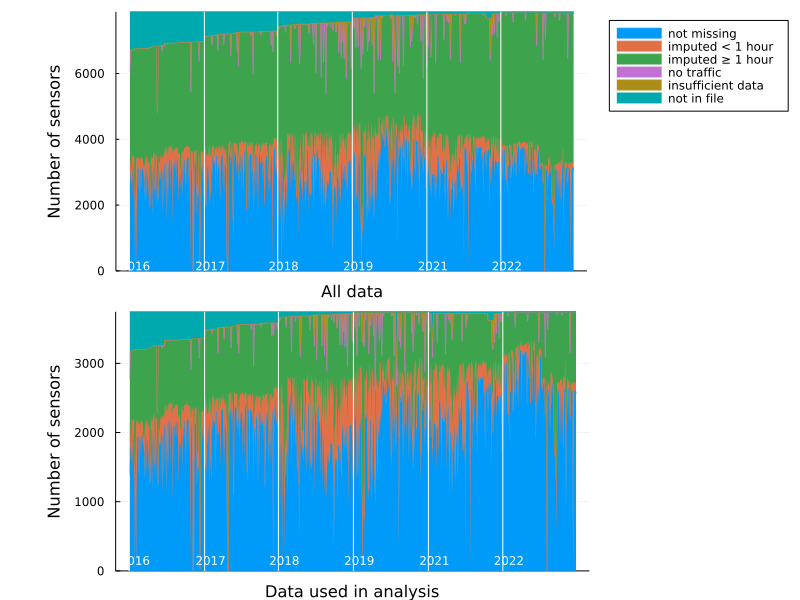

In [8]:
plot!(plot_all, xlabel="All data")
plot!(plot_used, legend=false, xlabel="Data used in analysis")
plot(plot_all, plot_used, plot(xticks=false, yticks=false, xaxis=false, yaxis=false), size=(800, 600), layout=@layout [
        a{1.0w}
        [b{0.73w} c{0.27w}]
    ])

# plot(plot_all, plot_used,size=(600, 800), layout=@layout [
#         a{0.4h}
#         b{0.6h}
#         ])

savefig("../fig/sensor_missingness.pdf")
plot!()

In [16]:
@pipe groupby(data, :missing_reason) |> combine(_, x -> nrow(x) / nrow(data))

,missing_reason,x1
,Symbol?,Float64
1,not_missing,0.358672
2,imputed_1hr_or_more,0.477373
3,imputed_less_than_1hr,0.10457
4,insufficient_data,0.0137738
5,no_traffic,0.0006324
6,not_in_file,0.0449792


## Does missingness explain away the difference?

In [60]:
# re-read data because we mutated it when plotting
data_final = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022, min_complete=0.0)
data_final = data_final[data_final.period .∈ Ref(Set([:prepandemic, :postlockdown])), :];

## Logistic regression model

We're doing a hypothesis test that spatial and temporal patterns did not change prepandemic to postpandemic by running a logistic regression with day of week, month, and county-road-direction fixed effects, and interacting them all with "postpandemic". Then we'll do a false discovery rate to see if the spatial/temporal pattern has changed.

In [28]:
model_data = leftjoin(select(data_used, Not([:Latitude, :Longitude, :District, :Lanes, :urban])), meta, on=:station=>:ID);

In [29]:
# patch up that periods, locations, directions are missing for new dates
model_data.period = KFactors.Periods.period_for_date.(model_data.date, Ref(KFactors.Periods.SPRING_2022))
model_data = model_data[model_data.period .!= :lockdown, :]
@assert !any(ismissing.(model_data.Latitude))
nothing

In [30]:
unique(model_data.missing_reason)

6-element Vector{Union{Missing, Symbol}}:
 :not_missing
 :imputed_1hr_or_more
 :imputed_less_than_1hr
 :insufficient_data
 :no_traffic
 :not_in_file

In [135]:
model_data.fwy_dir_group = @with model_data categorical(string.(:Fwy) .* "_" .* :Dir .* "_" .*
    string.(:County) .* "_" .* ifelse.(model_data.urban, ["urban"], ["not_urban"]))
model_data.Lanes = categorical(model_data.Lanes)
model_data.lane_group = recode(model_data.Lanes, missing, 1=>"1 or 2", 2=>"1 or 2", 3 => "3",
    4=>"4 or more", 5=>"4 or more", 6=>"4 or more", 7=>"4 or more", 8=>"4 or more")
@assert !any(ismissing.(model_data.lane_group))
model_data.dayofweek = categorical(Dates.dayname.(model_data.date))
model_data.month = categorical(Dates.monthname.(model_data.date))
model_data.anymissing = model_data.missing_reason .!= :not_missing
model_data.postlockdown = model_data.period .== :postlockdown
model_data.District = CategoricalArray(model_data.District)
model_data.proportion_missing = model_data.periods_imputed ./ 288
model_data.std_peak_hour_occ_mean = standardize(ZScoreTransform, model_data.peak_hour_occ_mean)
model_data.day_of_week = CategoricalArray(Dates.dayname.(model_data.date), ordered=true, levels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])
transform!(groupby(model_data, :station), :total_flow => mean ∘ skipmissing => :aadt,
    :peak_hour_occ => (x -> mean(filter(y -> !ismissing(y) && !isnan(y), x))) => :peak_hour_occ_mean)
model_data.flow_per_lane = model_data.aadt ./ convert.(Int64, model_data.Lanes)
model_data.std_flow_per_lane = standardize(ZScoreTransform, model_data.flow_per_lane)
model_data[
    model_data.missing_reason .∈ Ref(Set([:insufficient_data, :no_traffic, :not_in_file])),
    :proportion_missing] .= 1
nothing

In [137]:
ols = lm(@formula(proportion_missing ~ postlockdown*(District + urban + lane_group + std_flow_per_lane + std_peak_hour_occ_mean + day_of_week)), model_data)
olsHC = stderror(CRHC2(model_data.station), ols)
olsHC_t = coef(ols) ./ olsHC
tdist = TDist(nobs(ols) - length(olsHC_t) - 1) # overkill, could just use a normal dist...
olsHC_p = 2 * cdf.(tdist, -abs.(olsHC_t))
show(DataFrame(
    coefnames=coefnames(ols),
    coef=round.(coef(ols), digits=3),
    std=round.(olsHC, digits=3),
    t=round.(olsHC_t, digits=3),
    p=round.(olsHC_p, digits=3)
    ), allrows=true)

36×5 DataFrame
 Row │ coefnames                          coef     std      t        p       
     │ String                             Float64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────────────────────────────────
   1 │ (Intercept)                          0.335    0.021   15.738    0.0
   2 │ postlockdown                        -0.14     0.026   -5.438    0.0
   3 │ District: 4                         -0.033    0.02    -1.624    0.104
   4 │ District: 5                          0.041    0.023    1.762    0.078
   5 │ District: 6                         -0.055    0.023   -2.362    0.018
   6 │ District: 7                          0.042    0.021    1.949    0.051
   7 │ District: 8                          0.033    0.022    1.495    0.135
   8 │ District: 10                         0.159    0.024    6.678    0.0
   9 │ District: 11                        -0.135    0.021   -6.342    0.0
  10 │ District: 12                        -0.034    0.021   -1.62

In [83]:
@pipe groupby(model_data, [:District, :period]) |> combine(_, :proportion_missing => mean) |> unstack(_, :District, :period, :proportion_missing_mean)

,District,prepandemic,postlockdown
,Cat…?,Float64?,Float64?
1,3,0.30034,0.201595
2,4,0.260475,0.124827
3,5,0.352382,0.0363872
4,6,0.276588,0.0610186
5,7,0.330141,0.142475
6,8,0.332349,0.113731
7,10,0.484953,0.076042
8,11,0.156101,0.166513
9,12,0.264371,0.113447


In [79]:
# are imputed records systematically different from non-imputed ones?
occdata = model_data[.!ismissing.(model_data.peak_hour_occ) .&& .!isnan.(model_data.peak_hour_occ), :]
occmod = lm(@formula(peak_hour_occ ~ proportion_missing + postlockdown*fwy_dir_group), occdata)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

peak_hour_occ ~ 1 + proportion_missing + postlockdown + fwy_dir_group + postlockdown & fwy_dir_group

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                          Coef.   Std. Error        t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                                         0.107523     0.00309928     34.69    <1e-99   0.101448      0.113597
proportion_missing                                 -0.013248     0.000124927  -106.05    <1e-99  -0.0134929    -0.0130032
postlockdown                                       -0.0266836    0.00697742     -3.82    0.

In [69]:
cor(occdata.peak_hour_occ, occdata.urban)

NaN

In [76]:
sum(isnan.(occdata.peak_hour_occ))

587

In [16]:
# leaving year out due to collinearity with postpandemic, and also we don't differentiate prepandemic years in permutation test
logit = glm(@formula(anymissing ~ postlockdown*(fwy_dir_group + dayofweek + month)), model_data, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

anymissing ~ 1 + postlockdown + fwy_dir_group + dayofweek + month + postlockdown & fwy_dir_group + postlockdown & dayofweek + postlockdown & month

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                          Coef.   Std. Error       z  Pr(>|z|)      Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                                         -0.355162     0.0411874    -8.62    <1e-17   -0.435888     -0.274436
postlockdown                                         2.89929      0.1711       16.95    <1e-63    2.56394       3.23464
fwy_dir_group: 

In [17]:
tvals = coef(logit) ./ stderror(logit)
# TODO n-p-1 dof is correct yeah?
tdist = Distributions.TDist(nrow(model_data) - length(tvals) - 1)
pvals = (1 .- cdf.([tdist], abs.(tvals))) .* 2
# exclude the postpandemic main effect, we only care if spatial/temporal patterns changed
relevant_pvals = pvals[startswith.(coefnames(logit), ["postlockdown &"])]
nothing

### Multiple testing corrections

First, a simple Bonferroni correction.

In [18]:
mean(relevant_pvals .< 0.05 / length(relevant_pvals))

0.8126232741617357

### False discovery rate

Calculate the number of postpandemic interaction terms that are statistically significant, accounting for multiple-testing bias using a false discovery rate (Benjamini and Hochberg, 1995).

Not looking at the postpandemic base effect—we know the sensors got better. I think what we really care about is the distribution, although the overall base-rate change could affect analysis if the imputations are systematically biased.

In [19]:
# this is counting the number of p-values that are statistically significant with a FDR of 0.05
# from the FDR paper: Benjamini and Hochberg 1995
function false_discovery_rate(model, fdr; subset=nothing)
    if isnothing(subset)
       subset = coefnames(model)
    end
    
    selector = in.(coefnames(model), [Set(subset)])
    
    tvals = coef(model) ./ stderror(model)
    # TODO n-p-1 dof is correct yeah?
    tdist = Distributions.TDist(nobs(model) - length(tvals) - 1)
    pvals = (1 .- cdf.([tdist], abs.(tvals))) .* 2
    # exclude the postpandemic main effect, we only care if spatial/temporal patterns changed
    relevant_pvals = pvals[selector]
    relevant_coefnames = coefnames(model)[selector]
    pval_sort = sortperm(relevant_pvals)
    
    # "let k be the largest i for which P(i) ≤ i / m * q*" - Benjamini and Hochberg
    # julia uses 1-based indexing like Benjamini and Hochberg
    sig = relevant_pvals[pval_sort] .≤ (((1:length(relevant_pvals)) ./ length(relevant_pvals)) .* fdr)
    
    if !any(sig)
        return []
    end
    
    last_sig = findlast(x -> x, sig)
    
    # "then reject all [null hypotheses] H(i), i = 1, 2, ..., k
    sig[1:last_sig] .= true
    
    return relevant_coefnames[pval_sort][sig]
end

false_discovery_rate (generic function with 1 method)

In [20]:
fdrp = false_discovery_rate(logit, 0.05, subset=filter(c -> startswith(c, "postlockdown &"), coefnames(logit)))

422-element Vector{String}:
 "postlockdown & fwy_dir_group: 101_N_41_not_urban"
 "postlockdown & fwy_dir_group: 101_N_41_urban"
 "postlockdown & fwy_dir_group: 101_N_53_not_urban"
 "postlockdown & fwy_dir_group: 101_N_53_urban"
 "postlockdown & fwy_dir_group: 101_N_75_urban"
 "postlockdown & fwy_dir_group: 101_N_79_not_urban"
 "postlockdown & fwy_dir_group: 101_N_79_urban"
 "postlockdown & fwy_dir_group: 101_N_81_urban"
 "postlockdown & fwy_dir_group: 101_N_83_urban"
 "postlockdown & fwy_dir_group: 101_N_85_not_urban"
 "postlockdown & fwy_dir_group: 101_N_85_urban"
 "postlockdown & fwy_dir_group: 101_N_97_not_urban"
 "postlockdown & fwy_dir_group: 101_N_97_urban"
 ⋮
 "postlockdown & fwy_dir_group: 99_N_47_urban"
 "postlockdown & fwy_dir_group: 110_S_37_urban"
 "postlockdown & fwy_dir_group: 14_S_37_not_urban"
 "postlockdown & fwy_dir_group: 25_N_85_urban"
 "postlockdown & fwy_dir_group: 52_E_73_urban"
 "postlockdown & fwy_dir_group: 90_E_37_urban"
 "postlockdown & fwy_dir_group: 580_W_

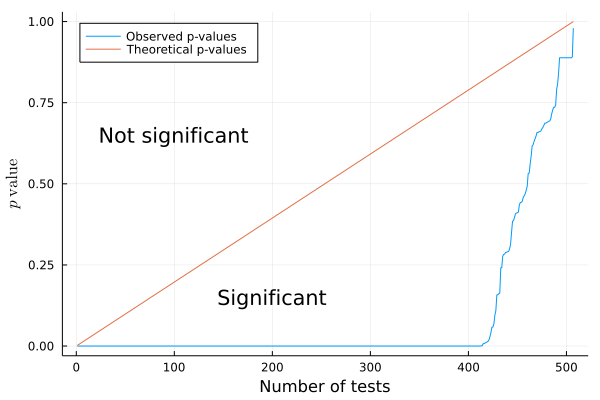

In [21]:
plot(1:length(relevant_pvals), sort(relevant_pvals), label="Observed p-values",
    legend=:topleft,
    xlab="Number of tests",
    ylab=L"p~\mathrm{value}"
)
plot!(1:length(relevant_pvals), (1:length(relevant_pvals)) ./ length(relevant_pvals), label="Theoretical p-values")
annotate!(
    (200, 0.15, "Significant"),
    (100, 0.65, "Not significant")
    )
savefig("../fig/pvals.pdf")
plot!()

### Practical significance

There's definitely statistical significance, but are the variables practically significant? Plot the distribution of odds ratios.

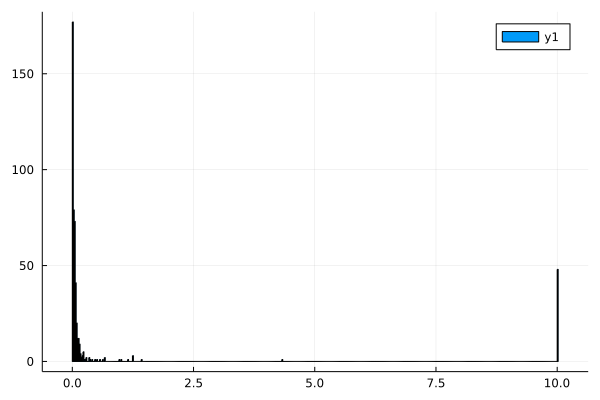

In [22]:
ors = exp.(coef(logit)[startswith.(coefnames(logit), ["postlockdown &"])])
histogram(ifelse.(ors .≥ 10, [10], ors))

In [23]:
quantile(ors, [0.05, 0.95])

2-element Vector{Float64}:
   0.0004908760037440509
 742.799821756911

In [24]:
pvdf = DataFrame(Dict(:coef=>coefnames(logit), :p=>pvals))
rel_pvdf = pvdf[startswith.(pvdf.coef, Ref("postlockdown & fwy")), :]
rel_pvdf.fwy_dir_group = map(x -> replace(x, r"^.* "=>""), rel_pvdf.coef)

501-element Vector{String}:
 "101_N_37_not_urban"
 "101_N_37_urban"
 "101_N_41_not_urban"
 "101_N_41_urban"
 "101_N_53_not_urban"
 "101_N_53_urban"
 "101_N_75_urban"
 "101_N_79_not_urban"
 "101_N_79_urban"
 "101_N_81_urban"
 "101_N_83_not_urban"
 "101_N_83_urban"
 "101_N_85_not_urban"
 ⋮
 "99_S_29_not_urban"
 "99_S_29_urban"
 "99_S_39_not_urban"
 "99_S_39_urban"
 "99_S_47_not_urban"
 "99_S_47_urban"
 "99_S_67_not_urban"
 "99_S_67_urban"
 "99_S_77_not_urban"
 "99_S_77_urban"
 "99_S_99_not_urban"
 "99_S_99_urban"

In [25]:
sensors_per_group = combine(groupby(model_data, :fwy_dir_group), :station => length ∘ unique => :n_stations);
sensors_per_group = leftjoin(sensors_per_group, rel_pvdf, on=:fwy_dir_group)

,fwy_dir_group,n_stations,coef
,Cat…,Int64,String?
1,101_N_37_not_urban,1,postlockdown & fwy_dir_group: 101_N_37_not_urban
2,101_N_37_urban,70,postlockdown & fwy_dir_group: 101_N_37_urban
3,101_N_41_not_urban,8,postlockdown & fwy_dir_group: 101_N_41_not_urban
4,101_N_41_urban,51,postlockdown & fwy_dir_group: 101_N_41_urban
5,101_N_53_not_urban,2,postlockdown & fwy_dir_group: 101_N_53_not_urban
6,101_N_53_urban,2,postlockdown & fwy_dir_group: 101_N_53_urban
7,101_N_75_urban,11,postlockdown & fwy_dir_group: 101_N_75_urban
8,101_N_79_not_urban,8,postlockdown & fwy_dir_group: 101_N_79_not_urban
9,101_N_79_urban,29,postlockdown & fwy_dir_group: 101_N_79_urban


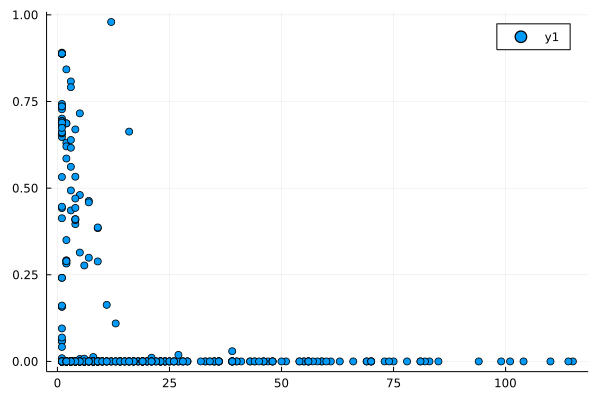

In [26]:
scatter(sensors_per_group.n_stations, sensors_per_group.p)

In [27]:
# what about just doing some simpler indicators: county*urban and day of week
logit = glm(@formula(anymissing ~ postlockdown*(County + Lanes + urban + dayofweek + month)), model_data, Binomial(), LogitLink(), contrasts=Dict(:Lanes=>DummyCoding()))

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

anymissing ~ 1 + postlockdown + County + Lanes + urban + dayofweek + month + postlockdown & County + postlockdown & Lanes + postlockdown & urban + postlockdown & dayofweek + postlockdown & month

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                            Coef.   Std. Error       z  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                           1.38441      0.0154761     89.46    <1e-99   1.35408       1.41474
postlockdown                         -1.53644      0.0310034    -49.56    <1e-99  -1.5972       -1.47567
County                               -0.002

In [28]:
exp.(coef(logit))

32-element Vector{Float64}:
   3.992478898803886
   0.21514655673838576
   0.9971051246034185
   0.9108083784610239
   0.6844101761104404
   0.5774993196157329
   0.6730834106774586
   0.7376909451198864
   0.7079419893162829
 193.97372650677195
   0.6962598920403047
   1.016183288581289
   1.387682352231826
   ⋮
   2.913876664280248
   3.010372487194055
   2.914953186163828
   5.055035042193633
   4.500343766890254
   1.6056646571139293
   0.9710955180865063
   0.7016231659469542
   0.6528308386980883
   0.703455609197732
   1.2068655875531171
   1.3445844611627378

## 